# Bank Customer Churn Prediction - Python Analysis Notebook
## Capstone Project | Fintech / Banking Domain | Data Science & Business Impact

This notebook serves as the core analytical engine for the Customer Churn Prediction project, focused on identifying high-risk churn customers within a retail banking context. All phases of the Python-based workflow — from data ingestion to machine learning modeling — will be executed here.

###  Objectives:
- Load and explore the Bank Churn dataset
- Clean and preprocess features for modeling
- Perform exploratory data analysis (EDA)
- Train classification models (Logistic Regression, Random Forest, XGBoost)
- Evaluate model performance using ROC-AUC, precision, recall, and confusion matrix
- Explain model results using feature importance and SHAP
- (Optional) Simulate A/B testing for retention campaign analysis

###  Dataset:
- Source: [Bank Customer Churn Dataset on Kaggle](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset)
- Size: ~10,000 rows × 12 columns
- Target Variable: `churn` (1 = churned)

> This notebook is designed to provide end-to-end insights and will be the central location for all data preprocessing, modeling, and interpretation tasks throughout the Capstone project.


In [6]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

In [7]:
# Load dataset
# Replace the path below with your actual file location
df = pd.read_csv('../data/Bank_Customer_Churn_Prediction.csv')
df.head()
# C:\Users\Yang Chen\Jupyter Notebook\bank-customer-churn-prediction\bank-customer-churn-prediction\data\Bank_Customer_Churn_Prediction.csv
# import os

# current_directory = os.getcwd()
# print(current_directory)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [9]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [10]:
df['churn'].value_counts(normalize=True)

churn
0    0.7963
1    0.2037
Name: proportion, dtype: float64

In [11]:
df['country'].value_counts(normalize=True)

country
France     0.5014
Germany    0.2509
Spain      0.2477
Name: proportion, dtype: float64

In [12]:
df['gender'].value_counts(normalize=True)

gender
Male      0.5457
Female    0.4543
Name: proportion, dtype: float64

In [13]:
# drop the useless column
df.drop('customer_id', axis=1, inplace=True)

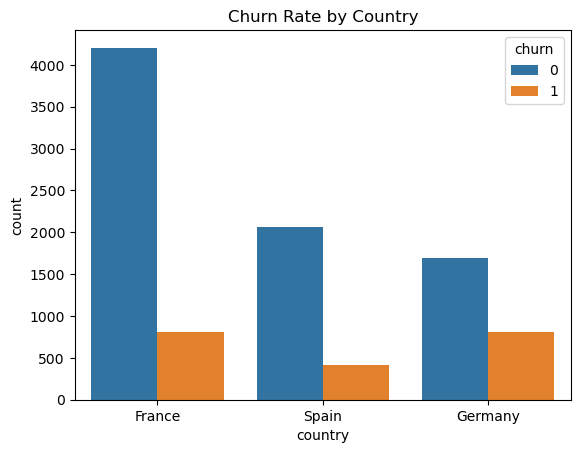

In [14]:
# Churn by Geography
sns.countplot(x='country', hue='churn', data=df)
plt.title('Churn Rate by Country')
plt.show()

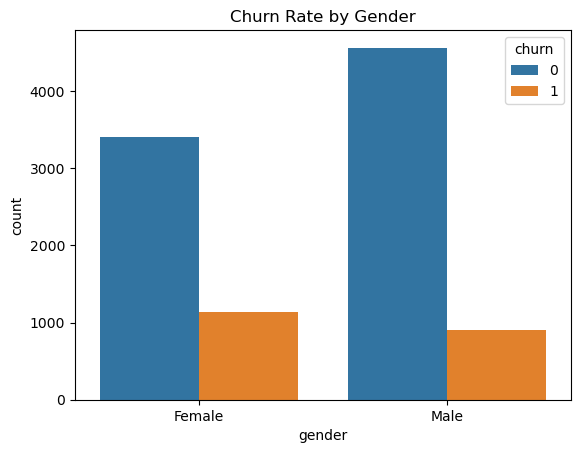

In [15]:
# Churn by Gender
sns.countplot(x='gender', hue='churn', data=df)
plt.title('Churn Rate by Gender')
plt.show()

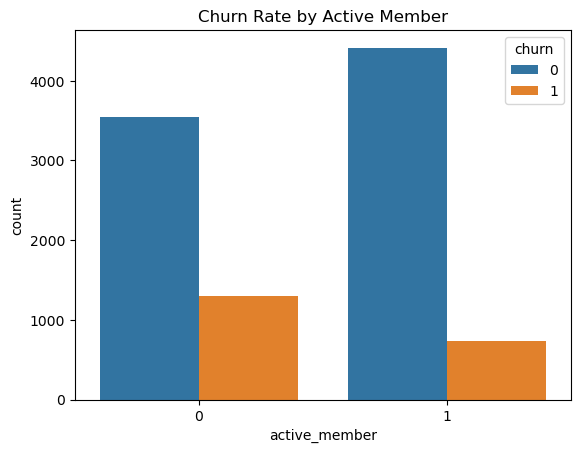

In [16]:
# Churn by Active
sns.countplot(x='active_member', hue='churn', data=df)
plt.title('Churn Rate by Active Member')
plt.show()

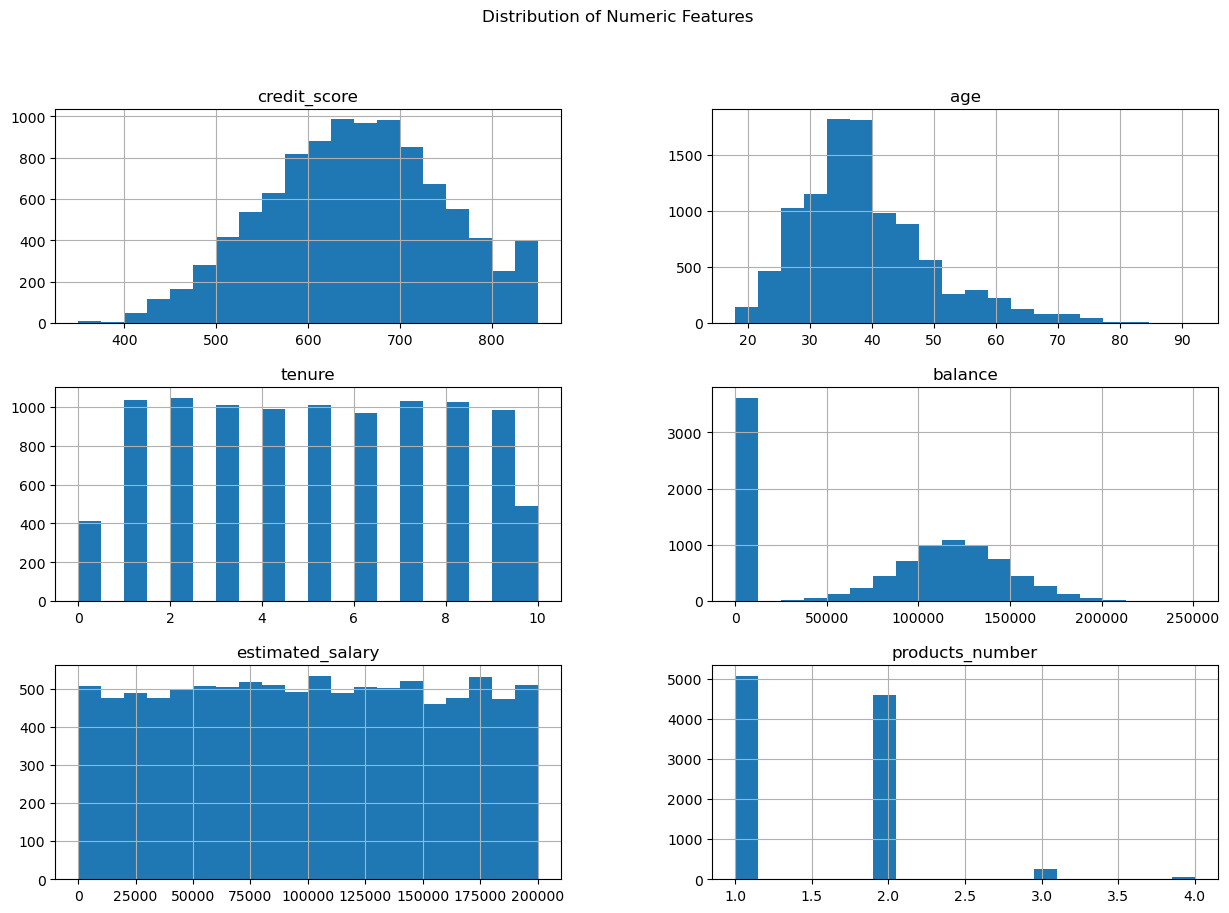

In [17]:
# Numeric Feature Distributions
num_cols = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary', 'products_number']
df[num_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of Numeric Features")
plt.show()

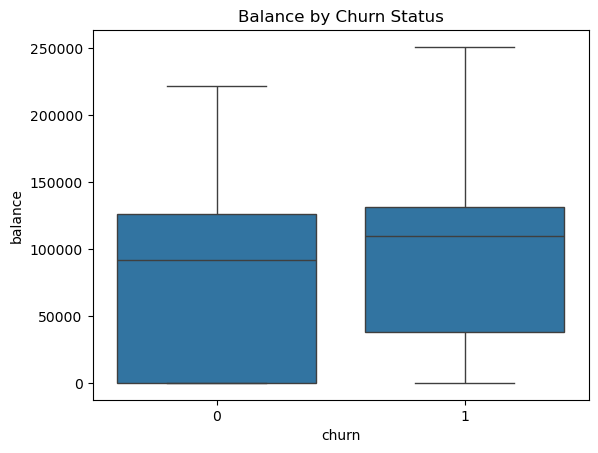

In [18]:
# Churn Rate vs balance
sns.boxplot(x='churn', y='balance', data=df)
plt.title("Balance by Churn Status")
plt.show()

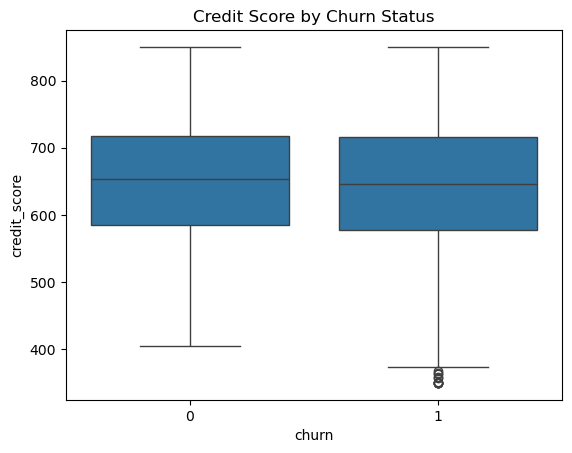

In [19]:
# Churn Rate vs credit score
sns.boxplot(x='churn', y='credit_score', data=df)
plt.title("Credit Score by Churn Status")
plt.show()

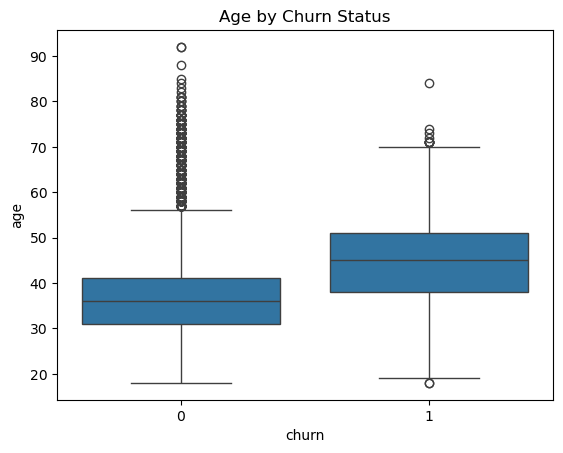

In [20]:
# Churn Rate vs age
sns.boxplot(x='churn', y='age', data=df)
plt.title("Age by Churn Status")
plt.show()

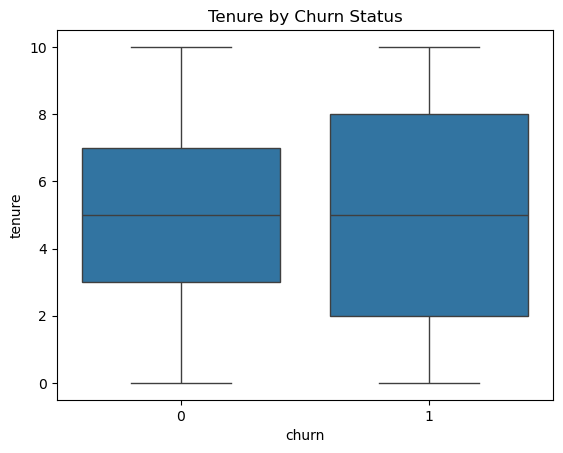

In [21]:
# Churn Rate vs tenure
sns.boxplot(x='churn', y='tenure', data=df)
plt.title("Tenure by Churn Status")
plt.show()

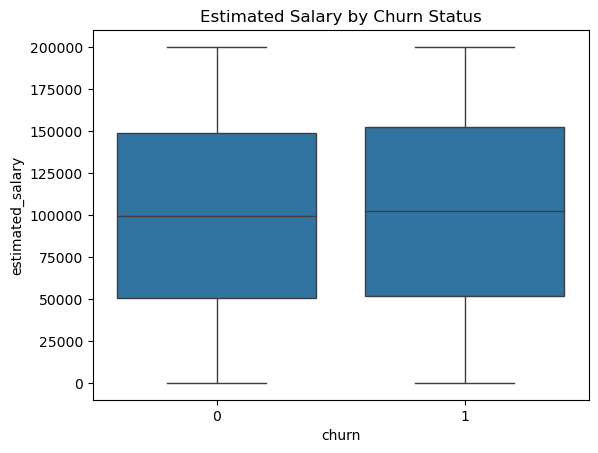

In [22]:
# Churn Rate vs estimated salary
sns.boxplot(x='churn', y='estimated_salary', data=df)
plt.title("Estimated Salary by Churn Status")
plt.show()

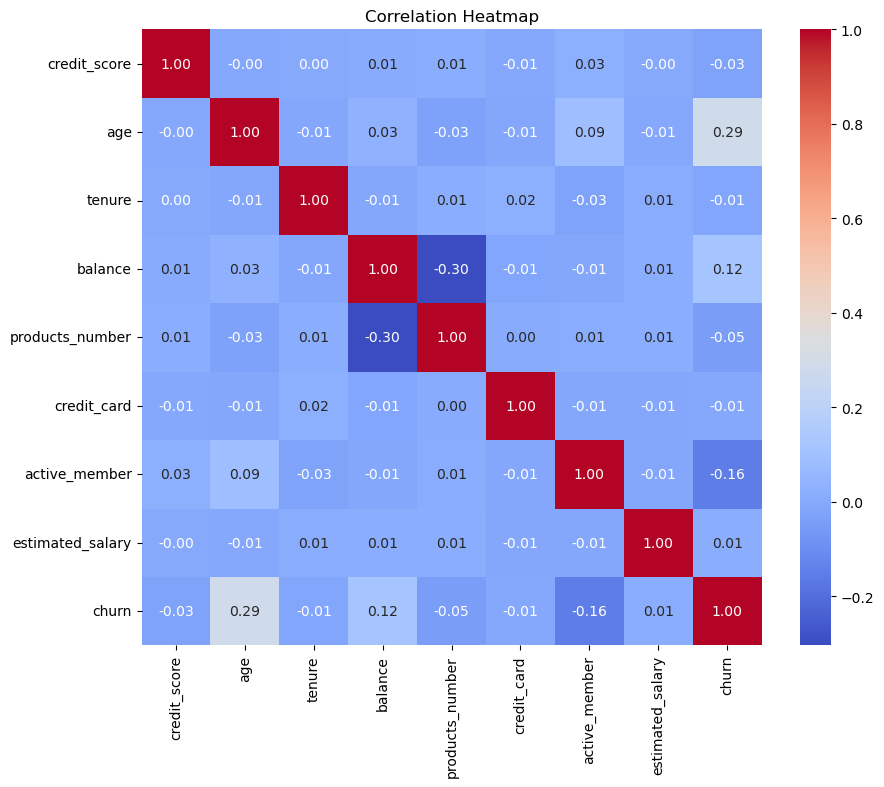

In [23]:
# Heatmap
df_filtered = df.loc[:, ~df.columns.isin(['country', 'gender'])]

corr = df_filtered.corr()
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [24]:
df.groupby('products_number')['churn'].mean().sort_values(ascending=False)

products_number
4    1.000000
3    0.827068
1    0.277144
2    0.075817
Name: churn, dtype: float64

In [25]:
'''products = 4 seems to be an outlier, 
And consider why 3 products have 83% churn rate 
'''
df['products_number'].value_counts(normalize=True)

products_number
1    0.5084
2    0.4590
3    0.0266
4    0.0060
Name: proportion, dtype: float64

In [26]:
df['products_grouped'] = df['products_number'].apply(lambda x: '3+' if x >= 3 else str(x))
df['products_grouped'].value_counts(normalize=True)

products_grouped
1     0.5084
2     0.4590
3+    0.0326
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Churn Rate by Product Group (Binned)')

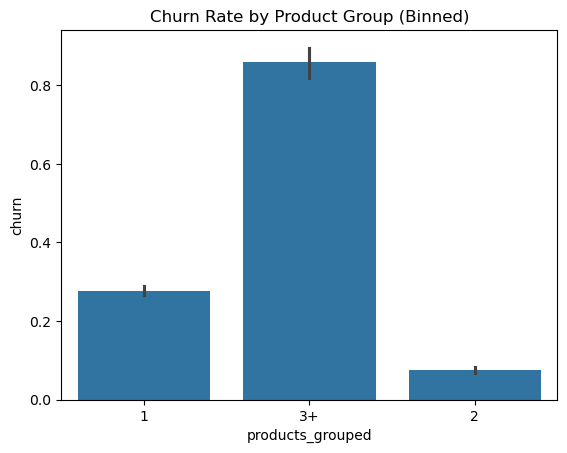

In [27]:
sns.barplot(x='products_grouped', y='churn', data=df)
plt.title("Churn Rate by Product Group (Binned)")

# Modeling Preprocessing
##  Top Variables Likely to Predict Churn
**Based on Exploratory Data Analysis:**

### Good Predictors:
- `age`: Older customers show higher churn probability.
- `active_member`: Inactive customers are more likely to churn.
- `products_number`: Customers with 3+ products have extremely high churn.
- `country_Germany`: German customers churn more than others (to be encoded).
- `balance`: May have a nonlinear relationship with churn.

### Weak Predictors:
- `estimated_salary`: Uniform distribution, little difference across churn.
- `credit_score`: Relatively flat relationship to churn.
- `tenure`: No strong visual correlation with churn.

> These insights will guide feature selection and help refine model input.



In [28]:
"""
What's the issue?
    Most machine learning models (like Logistic Regression, Random Forest, XGBoost) 
    can't process text data like "France" or "Male" — they require numerical inputs.
"""
# Outlier Handling
df['products_grouped'] = df['products_number'].apply(lambda x: '3+' if x >= 3 else str(x))
df['age_flag'] = df['age'].apply(lambda x: 1 if x > 70 else 0)
df['high_balance'] = df['balance'].apply(lambda x: 1 if x > 200000 else 0)

# One-Hot Encode
df_encoded = pd.get_dummies(df, columns=['country', 'gender', 'products_grouped'], drop_first=True)
df_encoded.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_flag,high_balance,country_Germany,country_Spain,gender_Male,products_grouped_2,products_grouped_3+
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,False,False,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,False,True,False,False,False
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,False,False,False,False,True
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,False,False,False,True,False
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,False,True,False,False,False


## Normailize the data

In [29]:
scale_cols = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
scaler = StandardScaler()
df_encoded[scale_cols] = scaler.fit_transform(df_encoded[scale_cols])

X = df_encoded.drop('churn', axis=1)
y = df_encoded['churn']

In [30]:
# Train-Test Split the dtaset
# 30% reservved for testing, 70% for training by test_size=0.3
# X_train, y_train: used to train the model
# X_test, y_test: used to test how well it performs on unseen data
# random_state=42 ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Train the model

In [31]:
# Initialize the model: logistic regression, random forest, etc.
lr = LogisticRegression()
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# train the model: logistic regression, random forest, etc.
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
# predict the test set
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

## Evaluation the Model

In [32]:
# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.2f}")

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}\n")

Logistic Regression Accuracy: 0.85
Random Forest Accuracy: 0.87
XGBoost Accuracy: 0.86



In [33]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2416
           1       0.72      0.41      0.52       584

    accuracy                           0.85      3000
   macro avg       0.79      0.69      0.72      3000
weighted avg       0.84      0.85      0.84      3000

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.78      0.48      0.59       584

    accuracy                           0.87      3000
   macro avg       0.83      0.72      0.76      3000
weighted avg       0.86      0.87      0.86      3000

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2416
           1       0.70      0.51      0.59       584

    accuracy                           0.86      3000
   macro avg       0.79      0.73    

### Comparison Summary (Churn Class = 1)
- Random Forest has best precision of 78% mean it will have fewer false positives
- XGBoost has best recall (catches more churners), valuable for churn prevention
- F1-score: XGBoost is similar to Random Forest, both significantly better than Logistic Regression

> XGBoost might be best model to use for catch as many churner as possible

## ROC Curve Comparison

To compare the performance of different models in distinguishing churn vs non-churn customers, we plot the ROC (Receiver Operating Characteristic) curve and compute the AUC (Area Under the Curve). A model with a higher AUC score is better at separating the classes.

- **True Positive Rate (TPR)**: Sensitivity, Recall — % of actual churners correctly identified  
- **False Positive Rate (FPR)**: % of non-churners wrongly predicted as churn  
- **Baseline (diagonal)**: Model performs no better than random guessing

The closer the curve is to the top-left corner, the better the model performs.  

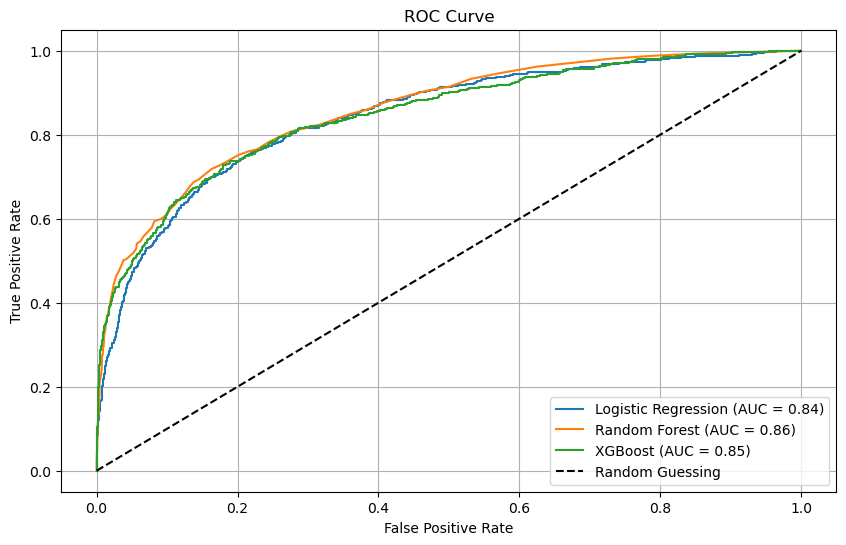

In [34]:
# Predict probabilities (class = 1)
y_prob_lr = lr.predict_proba(X_test)[:, 1]
y_prob_rf = rf.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# calculate ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

# Calculate AUC
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()



### ROC AUC Notes
> area under the receiver operating characteristic curve, is **a metric used to evaluate the performance of a binary classification model**. It measures the model's ability to discriminate between positive and negative classes across all possible classification thresholds.

## Model Performance Comparison

| Model | Accuracy| Precision (Churn)| Recall (Churn)| F1-Score (Churn)| ROC AUC|
|-----------|------|-----------|---------|--------|-------|
| Logistic Regression| 0.85 | 0.72 | 0.41 | 0.52| 0.84|
| Random Forest| 0.87 | 0.78| 0.48| 0.59| 0.86|
| XGBoost | 0.86| 0.70| **0.51**| **0.59**| **0.85** |


**Insight:**  
While all three models performed reasonably well, XGBoost demonstrated the best trade-off between precision and recall for the churn class, with the highest recall (51%) and strong F1-score (0.59). This makes XGBoost the most suitable model for applications focused on identifying and retaining churn-prone customers.

**Business Value:**  
Using XGBoost, the company can catch more than half of potential churners with acceptable false alarm rates — enabling early intervention strategies such as loyalty offers or personalized outreach.


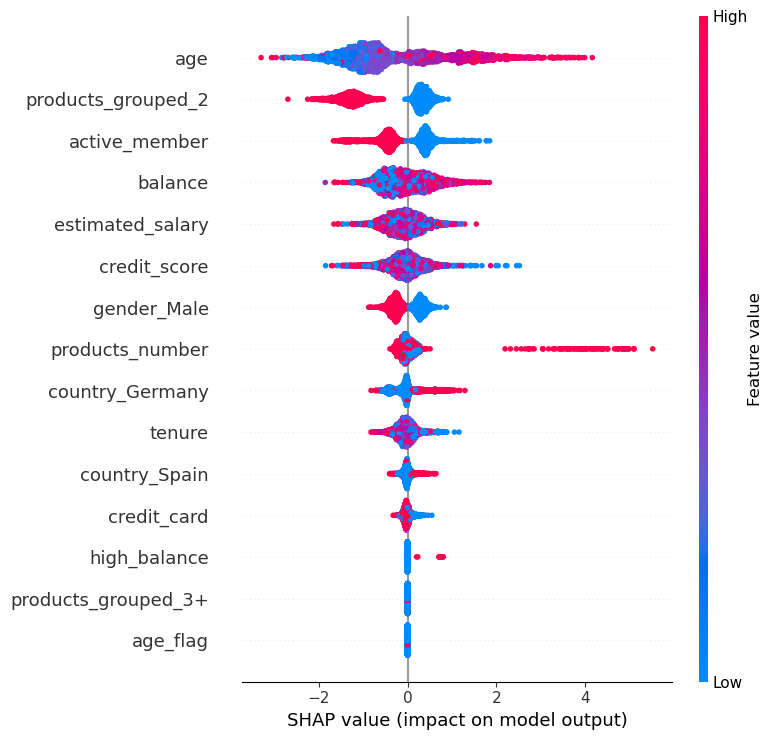

In [35]:
# create a SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(xgb)

# Compute SHAP values on the test set
shap_values = explainer.shap_values(X_test)

# Plot global feature importance (summary)
shap.summary_plot(shap_values, X_test)

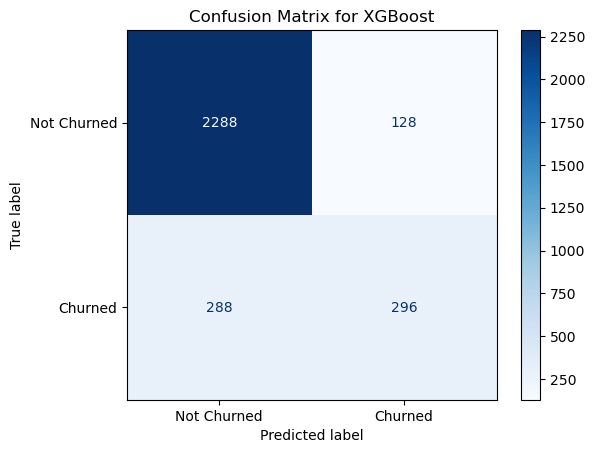

In [36]:
# Compute confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Not Churned', 'Churned'])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for XGBoost")
plt.grid(False)
plt.show()

- **Top-left (TN)**: Customers correctly predicted as not churning
- **Bottom-right (TP)**: Customers correctly identified as churners
- **Top-right (FP)**: Customers wrongly predicted as churners (false alarms)
- **Bottom-left (FN)**: Actual churners the model missed — business risk!

**Goal:** Increase True Positives and reduce False Negatives to retain more customers.


##  Final Model Evaluation Summary

This project aimed to build a predictive model for customer churn using structured data from a fintech/banking context. Three classification models were evaluated: Logistic Regression, Random Forest, and XGBoost.

###  Best Performing Model: **XGBoost**

| Metric| Logistic Regression | Random Forest | XGBoost |
|--|--|--|--|
| Accuracy| 0.85| **0.87**| 0.86|
| Precision (Churn)| 0.72| **0.78**| 0.70|
| Recall (Churn)| 0.41 | 0.48 | **0.51** |
| F1-Score (Churn)| 0.52 | 0.59 | **0.59** |
| ROC AUC| 0.84 | **0.86** | 0.85 |

>  **XGBoost** achieved the best balance of precision and recall, identifying 51% of actual churners with a strong F1-score of 0.59.

---

###  Key Insights from SHAP (Explainable AI)
- **Age** is the top driver of churn — older customers are more likely to leave.
- **Inactive members** are strongly associated with higher churn risk.
- Customers with **exactly 2 products** are significantly **less likely to churn**, suggesting product bundling may improve retention
- **Female customers** show a slightly higher churn tendency compared to male customers.
- A **high account balance** is associated with a higher likelihood of churn, possibly due to risk-aware high-value clients.


---

###  Business Impact

- This model enables early identification of at-risk customers.
- SHAP explanations provide transparency for business teams to act on.
- Combined with targeted retention offers (e.g., for older, inactive users), this can reduce churn and boost customer lifetime value.



ROC AUC: 0.7738390042411323
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      2416
           1       0.64      0.42      0.51       584

    accuracy                           0.84      3000
   macro avg       0.76      0.68      0.71      3000
weighted avg       0.83      0.84      0.83      3000



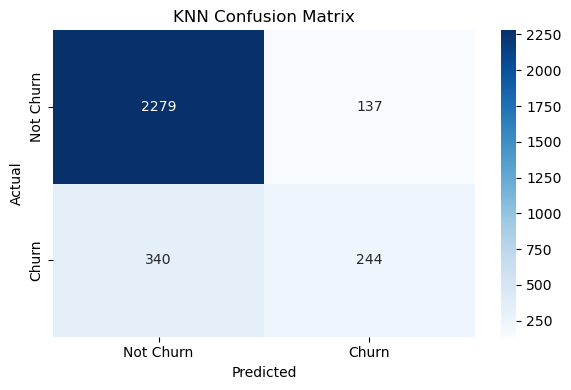

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Step 3: Predict
y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]

# Step 4: Evaluation
print("ROC AUC:", roc_auc_score(y_test, y_prob_knn))
print(classification_report(y_test, y_pred_knn))

# Step 5: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
plt.title("KNN Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


## Try with K-Nearest Neighbors

> K-Nearest Neighbors was tested as a benchmark model. While it demonstrated moderate accuracy, its lower recall and AUC made it less suitable for identifying churn-prone customers compared to tree-based models like XGBoost and Random Forest. Therefore, it was excluded from the final deployment recommendation.

In [39]:
import joblib

# Save model
joblib.dump(xgb, "../models/xgboost_churn_model.pkl")
joblib.dump(scaler, "../models/standard_scaler.pkl")
# C:\Users\Yang Chen\Jupyter Notebook\bank-customer-churn-prediction\bank-customer-churn-prediction\data\Bank_Customer_Churn_Prediction.csv
# import os

# current_directory = os.getcwd()
# print(current_directory)

['../models/standard_scaler.pkl']